In [1]:
import os
import json
import h5py
import numpy as np

import robomimic
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim import Adam 
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from copy import deepcopy
import datetime
import tqdm

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/ns1254/mimicgen/envs/robomimic/robomimic/scripts/setup_macros.py
)


In [2]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
dataset_path = "/home/ns1254/data_robomimic/nn/can_image_v141_20p.hdf5"
filter_key_train = "20_percent_train"
filter_key_valid = "20_percent_valid"

f = h5py.File(dataset_path, "r")
demos = list(f["data"].keys())
num_demos = len(demos)
print(f'Number of demos: {num_demos}')

Number of demos: 40


In [4]:
f['data'][demos[0]]['obs'].keys()

<KeysViewHDF5 ['agentview_image', 'object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_eye_in_hand_image', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel']>

In [5]:
select_keys=['agentview_image', 'robot0_eye_in_hand_image', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']

In [69]:
for key in select_keys:
    print(key, f['data'][demos[0]]['obs'][key].shape)

agentview_image (129, 84, 84, 3)
robot0_eye_in_hand_image (129, 84, 84, 3)
robot0_eef_pos (129, 3)
robot0_eef_quat (129, 4)
robot0_gripper_qpos (129, 2)


In [6]:
demos_train=[b.decode('utf-8') for b in f["mask"][filter_key_train]]
demos_valid=[b.decode('utf-8') for b in f["mask"][filter_key_valid]]
len(demos_train), len(demos_valid)

(36, 4)

In [7]:
def encode_multi_input_dumb(obss):
    """
    obss: list of observations i.e. images, robot states etc.
    return Tx -1
    """
    T = obss[0].shape[0]  # length of the trajectory
    return np.hstack([np.array(obs).reshape(T, -1) for obs in obss])

In [8]:
def load_states_actions(f, demo_names):
    actions_list=[]
    obs_list=[]
    for i,demo_id in enumerate(demo_names): 
        traj=f['data'][demo_id]
    
        actions=traj['actions']
        select_obs=[traj['obs'][key] for key in select_keys] 
        actions_list.append(actions)
        obs_list.append(select_obs)

    all_states = np.vstack([encode_multi_input_dumb(obss) for obss in obs_list])
    all_actions = np.vstack(actions_list)
    return all_states, all_actions

In [9]:
states_train, actions_train = load_states_actions(f, demos_train)
states_valid, actions_valid = load_states_actions(f, demos_valid)
states_train.shape, actions_train.shape, states_valid.shape, actions_valid.shape

((4177, 42345), (4177, 7), (440, 42345), (440, 7))

In [10]:
data_loader_train = DataLoader( list(zip(states_train, actions_train)), batch_size=128, shuffle=True)
data_loader_valid = DataLoader( list(zip(states_valid, actions_valid)), batch_size=128, shuffle=True)

batch=next(iter(data_loader_train))
states,actions = batch
states.shape,actions.shape

(torch.Size([128, 42345]), torch.Size([128, 7]))

In [11]:
action_dim=actions.shape[1]
state_dim=states.shape[1]
print(state_dim, action_dim)

42345 7


In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, layer_dims, action_dim):
        super(MLP, self).__init__()
        self.encoder= nn.ModuleList()
        for i in range(len(layer_dims)):
            if i==0: 
                self.encoder.append(nn.Linear(input_dim, layer_dims[i]))
            else:
                self.encoder.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            self.encoder.append(nn.ReLU())

        self.dropout = nn.Dropout(0.2)
        self.decoder = nn.Linear(layer_dims[-1], action_dim)

    def forward(self,x):
        for module in self.encoder:
            x = module(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x 

In [13]:
learning_rate = 1e-5

bc = MLP(state_dim, [1024, 256], action_dim).to(device)
criterion = nn.MSELoss() 
optimizer = Adam(bc.parameters(), lr = learning_rate)

In [14]:
loss_list = [] 
n_epoch = 200
losses=[]
losses_valid=[]
for itr in tqdm.tqdm(range(1, n_epoch+1)):
    bc.train()
    train_loss = 0
    b=0
    for batch_states, batch_actions in data_loader_train: 
        batch_states = batch_states.to(device)
        batch_actions = batch_actions.to(device)
        y_pred = bc(batch_states.float())
        loss   = criterion(y_pred, batch_actions.float()) 
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1  
        loss_list.append(loss.item()) 
    
    train_loss=train_loss/b
    losses.append(train_loss)
 
    
    bc.eval()
    valid_loss=0
    b=0
    with torch.no_grad():
        for batch_states, batch_actions in data_loader_valid: 
            batch_states = batch_states.to(device)
            batch_actions = batch_actions.to(device)
            y_pred = bc(batch_states.float())
            loss   = criterion(y_pred, batch_actions.float()) 
            valid_loss += loss.item() 
            b += 1
    valid_loss=valid_loss/b
    losses_valid.append(valid_loss)
    
    if itr % (n_epoch//10) == 0:
        print(f'Epoch {itr} Train.Loss: {train_loss:.4f} Valid.Loss: {valid_loss:.4f}')

 10%|█         | 20/200 [00:10<01:24,  2.12it/s]

Epoch 20 Train.Loss: 0.1627 Valid.Loss: 0.1386


 20%|██        | 40/200 [00:20<01:14,  2.14it/s]

Epoch 40 Train.Loss: 0.1319 Valid.Loss: 0.1132


 30%|███       | 60/200 [00:30<01:17,  1.81it/s]

Epoch 60 Train.Loss: 0.1186 Valid.Loss: 0.0968


 40%|████      | 80/200 [00:41<01:09,  1.72it/s]

Epoch 80 Train.Loss: 0.1063 Valid.Loss: 0.0914


 50%|█████     | 100/200 [00:52<00:53,  1.86it/s]

Epoch 100 Train.Loss: 0.0984 Valid.Loss: 0.0843


 60%|██████    | 120/200 [01:03<00:40,  1.96it/s]

Epoch 120 Train.Loss: 0.0929 Valid.Loss: 0.0829


 70%|███████   | 140/200 [01:12<00:27,  2.17it/s]

Epoch 140 Train.Loss: 0.0899 Valid.Loss: 0.0870


 80%|████████  | 160/200 [01:21<00:18,  2.16it/s]

Epoch 160 Train.Loss: 0.0914 Valid.Loss: 0.0806


 90%|█████████ | 180/200 [01:31<00:09,  2.15it/s]

Epoch 180 Train.Loss: 0.1017 Valid.Loss: 0.0845


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]

Epoch 200 Train.Loss: 0.0938 Valid.Loss: 0.0679


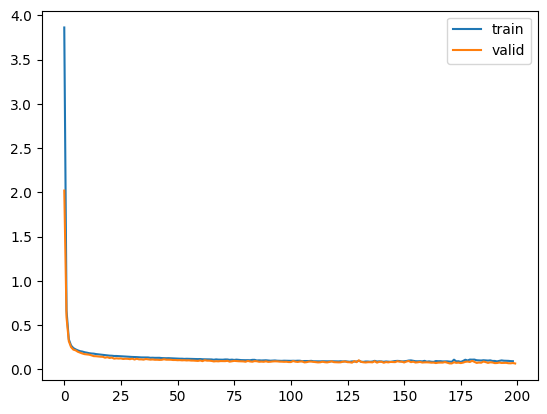

In [68]:
plt.plot(losses[1:], label='train')
plt.plot(losses_valid, label='valid')
plt.legend()

In [31]:
env_meta = json.loads(f["data"].attrs["env_args"])

In [32]:
env_meta

{'env_name': 'PickPlaceCan',
 'env_version': '1.4.1',
 'type': 1,
 'env_kwargs': {'has_renderer': False,
  'has_offscreen_renderer': True,
  'ignore_done': True,
  'use_object_obs': True,
  'use_camera_obs': True,
  'control_freq': 20,
  'controller_configs': {'type': 'OSC_POSE',
   'input_max': 1,
   'input_min': -1,
   'output_max': [0.05, 0.05, 0.05, 0.5, 0.5, 0.5],
   'output_min': [-0.05, -0.05, -0.05, -0.5, -0.5, -0.5],
   'kp': 150,
   'damping': 1,
   'impedance_mode': 'fixed',
   'kp_limits': [0, 300],
   'damping_limits': [0, 10],
   'position_limits': None,
   'orientation_limits': None,
   'uncouple_pos_ori': True,
   'control_delta': True,
   'interpolation': None,
   'ramp_ratio': 0.2},
  'robots': ['Panda'],
  'camera_depths': False,
  'camera_heights': 84,
  'camera_widths': 84,
  'reward_shaping': False,
  'camera_names': ['agentview', 'robot0_eye_in_hand'],
  'render_gpu_device_id': 0}}

In [ ]:
env = EnvUtils.create_env_from_metadata(
    env_meta=env_meta,  
    render=False, 
    render_offscreen=True,
    use_image_obs=True,
    use_depth_obs=False,
)
dummy_spec = dict(  obs=dict( low_dim=['robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos'], rgb=['agentview_image', 'robot0_eye_in_hand_image'], ),)
ObsUtils.initialize_obs_utils_with_obs_specs(obs_modality_specs=dummy_spec)

Created environment with name PickPlaceCan
Action size is 7


In [63]:
def rollout(env, rollout_horizon = 400, video_path=None):
    total_reward=0 
    select_keys=['agentview_image', 'robot0_eye_in_hand_image', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']

    obs = env.reset()
    state_dict = env.get_state()
    # hack that is necessary for robosuite tasks for deterministic action playback
    obs = env.reset_to(state_dict)

    if video_path is not None:
        video_writer = imageio.get_writer(video_path, fps=20)
        print(f"Writing video to {video_path}")
    camera_names=["agentview"]

    for step_i in range(rollout_horizon):
        obss=[obs[key][None,] for key in select_keys] 

        select_obs=encode_multi_input_dumb(obss)

        state=torch.from_numpy(select_obs).float()
        # state=state.to(device='cuda')

        act = bc(state.to(device)).detach().cpu().numpy()
        next_obs, r, done, _ = env.step(act.squeeze())

        # compute reward
        total_reward += r
        success = env.is_success()["task"]

        if video_path is not None:
            video_img = env.render(mode="rgb_array", height=512, width=512, camera_name="agentview")
            video_writer.append_data(video_img)


        # break if done or if success
        if done or success:
            # print(f'stop: done={done} success={success}')
            break

        # update for next iter
        obs = deepcopy(next_obs)

    if video_path is not None:
        video_writer.close()
    return total_reward

In [64]:
n_rollout=20
s=0
for i in range(n_rollout):
    r=rollout(env, video_path=None)
    s+=r
    print(f'Rollout {i} Success: {r}')

print(f'\nAverage Reward: {s/n_rollout:.2f}')

Rollout 0 Success: 0.0
Rollout 1 Success: 0.0
Rollout 2 Success: 0.0
Rollout 3 Success: 0.0
Rollout 4 Success: 0.0
Rollout 5 Success: 0.0
Rollout 6 Success: 0.0
Rollout 7 Success: 0.0
Rollout 8 Success: 0.0
Rollout 9 Success: 0.0
Rollout 10 Success: 0.0
Rollout 11 Success: 0.0
Rollout 12 Success: 0.0
Rollout 13 Success: 0.0
Rollout 14 Success: 0.0
Rollout 15 Success: 0.0
Rollout 16 Success: 0.0
Rollout 17 Success: 0.0
Rollout 18 Success: 0.0
Rollout 19 Success: 0.0

Average Reward: 0.00


In [66]:
r=rollout(env, video_path="can_bc.mp4")
r

Writing video to can_bc.mp4


0.0